# Chapter 7
## Recurrent neural networks


    Hand-in bug-free (try "Kernel" > "Restart & Run All") and including all (textual as well as figural) output via Blackboard before the deadline (see Blackboard).

Learning goals:
1. Get familiar with recurrent hidden units
1. Implement a simple recurrent neural network (Elman network)
1. Implement an LSTM-based neural network

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import chainer
import chainer.functions as F
from chainer.datasets import TupleDataset
from chainer import Chain
import chainer.links as L
import tqdm

### Exercise 1  (1 point)

Consider a recurrent neural network with one input unit $x$, one sigmoid recurrent hidden unit $h$, and one linear output unit $y$. The values of $x$ are given for 3 time points in `x_t`. As this is a very small RNN, $W^i$, $W^h$ and $W^o$ are given as the scalar values `w_i`, `w_h` and `w_o` respectively. The hidden unit has an added bias `h_bias`. The hidden unit state is initialized with `0.0`. The only 'value-manipulating' activation function in this network is the sigmoid activation $\sigma(\cdot)$ on the hidden unit. 

1. Write down the forward pass of this network for a specific time point $t$. 
1. What is the value of the hidden state $h$ after processing the last input `x_t[2]`? 
1. What is the output `y` of the network after processing the last input `x_t[2]`? 

\begin{eqnarray*}
h_t &=& w_i * x_t + w_h * h_{t-1} + h_{bias}\\ 
y_t &=& w_o * \sigma(h_t) \\
\end{eqnarray*}

It is unclear for us where the activation function should occur. 


You can either compute the solution by hand (show clearly how you arrived there, 3 decimal points) or write code to find the answer. 

In [5]:
# inputs over times 0, 1, 2:
x_t = [9.0, 4.0, -2.0]

# weights and bias terms: 
w_i = 0.5
w_h = -1.0
w_o = -0.7
h_bias = -1.0
y_bias = 0.0

### Solution 1

In [6]:
def sigmoid(z):
    return 1/(1+np.exp(z))

h_0 = w_i * x_t[0] + w_h * 0 + h_bias
y_0 = w_o * sigmoid(h_0)

h_1 = w_i * x_t[1] + w_h * h_0 + h_bias
y_1 = w_o * sigmoid(h_1)

h_2 = w_i * x_t[2] + w_h * h_1 + h_bias
y_2 = w_o * sigmoid(h_2)

print("value h_2: ", h_2)
print("value y_2: ", y_2)

('value h_2: ', 0.5)
('value y_2: ', -0.26427846815870176)


### Code introduction

We will apply two recurrent neural networks to learn a dynamic variant of the *adding problem*. First, run the next cell and check the output. 

There is a stream of inputs to the network, two at each time step. The first input unit will receive a series of decimal numbers in the interval $[-1,1]$. The second input unit will receive the numbers $0$, $-1$, and $1$. The target is the sum of the preceding two decimal numbers that came together with the number $1$ (called the marker, `x` in the generated output), and it should be produced whenever a marker has been seen. In the beginning until two of these markers have been seen, the input will stay 0. 


Below you will find several functions: 
1. `create_addition_data`: Generates sequential training data sets `X` and `T` for the dynamic *adding problem*, returns a `TupleDataset` for `chainer`.
1. `SequentialIterator`: An `Iterator` determines in which order to traverse a training data set. If you have separate individual examples it is best to use a random order. As our data set is sequential, we need to go through it from beginning to end, which is what we implement in this custom `Iterator`. 
1. `train_model`: A function that takes your model definition and the generated data, and trains the parameters accordingly.
4. `Regressor`: Structure for defining a regression problem. Calls a `predictor` (model doing regression) with an input and returns the error between its output and the desired output. 

Code example for generating your data and setting up the `SequentialIterator` on it:  

`train_iter = SequentialIterator( create_addition_data(n_samples), batch_size=batch_size )`


Code example for training a model:

`model, train_loss, test_loss = train_model( train_iter, test_iter, n_epochs=n_epochs)`

In [8]:
def create_addition_data(n_samples=3000):
    # This is a dynamic variant of the adding problem. 
    
    # random numbers in [-1.0,1.0]): 
    X1 = np.random.uniform(low=-1.0, high=1.0, size=(n_samples,) )   
    
    # random markers [-1.0, 0.0, 1.0] (1.0 marks the numbers that should be added):
    X2 = np.random.choice([-1.0,0.0,1.0], size=(n_samples,), p=[0.475,0.475,0.05])
    # combine
    X = np.vstack((X1, X2)).T.astype('float32')

    # create targets
    T = np.zeros( (n_samples,1) ).astype('float32')

    markers = np.nonzero(X2==1.0)[0]   # get indices of 1.0
    
    mem = X1[ markers[0] ]
    for mi, marker in enumerate(markers[1:]):
        T[marker] = mem + X1[ marker ]
        mem = X1[ marker ]
                
    return TupleDataset(X, T)


n = 70  # long as the markers x are sparse

print "Example data for the adding problem (x marks 1.0):"
data = create_addition_data(n_samples=n)

for t in xrange(n):
    print "Time=%2d:   x: (%+.2f , %s )  |  t:  %+.2f " % (t, data[t][0][0], 
                                                        'x' if data[t][0][1] == 1.0 else ' ', 
                                                        data[t][1])

Example data for the adding problem (x marks 1.0):
Time= 0:   x: (+0.95 ,   )  |  t:  +0.00 
Time= 1:   x: (+0.16 ,   )  |  t:  +0.00 
Time= 2:   x: (-1.00 ,   )  |  t:  +0.00 
Time= 3:   x: (+0.81 ,   )  |  t:  +0.00 
Time= 4:   x: (-0.69 , x )  |  t:  +0.00 
Time= 5:   x: (-0.12 ,   )  |  t:  +0.00 
Time= 6:   x: (+0.11 ,   )  |  t:  +0.00 
Time= 7:   x: (+0.23 ,   )  |  t:  +0.00 
Time= 8:   x: (+0.49 ,   )  |  t:  +0.00 
Time= 9:   x: (+0.79 ,   )  |  t:  +0.00 
Time=10:   x: (-0.88 ,   )  |  t:  +0.00 
Time=11:   x: (+0.14 ,   )  |  t:  +0.00 
Time=12:   x: (+0.68 ,   )  |  t:  +0.00 
Time=13:   x: (+0.10 ,   )  |  t:  +0.00 
Time=14:   x: (-0.34 ,   )  |  t:  +0.00 
Time=15:   x: (+0.70 ,   )  |  t:  +0.00 
Time=16:   x: (-0.59 ,   )  |  t:  +0.00 
Time=17:   x: (+0.62 ,   )  |  t:  +0.00 
Time=18:   x: (+0.36 ,   )  |  t:  +0.00 
Time=19:   x: (-0.40 ,   )  |  t:  +0.00 
Time=20:   x: (-0.59 ,   )  |  t:  +0.00 
Time=21:   x: (-0.48 ,   )  |  t:  +0.00 
Time=22:   x: (-0.75 ,   

In [9]:
class SequentialIterator(object):

    def __init__(self, data, batch_size=1):
        self.data = data

        self.batch_size = batch_size
        self.n_batches = len(self.data) // batch_size

    def __iter__(self):

        self.idx = -1

        offsets = [i * self.n_batches for i in range(self.batch_size)]

        # define custom ordering; we won't process beyond the end of the trial
        self._order = []
        for iter in range(self.n_batches):
            x = [(offset + iter) % len(self.data) for offset in offsets]
            self._order += x

        return self

    def next(self):

        self.idx += 1

        if self.idx == self.n_batches:
            raise StopIteration

        i = self.idx * self.batch_size
        
        test = list(self.data[self._order[i:(i + self.batch_size)]])

        return list(self.data[self._order[i:(i + self.batch_size)]])

In [10]:
def train_network(model, n_samples=3000, n_epochs=100): 
    
    batchsize = 20
    
    # Define data iterators
    train_iter = SequentialIterator(create_addition_data(n_samples), batch_size=batchsize)
    test_iter  = SequentialIterator(create_addition_data(n_samples), batch_size=batchsize)
    
    cutoff = n_samples / batchsize - 1
    cutoff = 70

    # Preallocate memory for losses
    train_loss = np.zeros(n_epochs)
    test_loss = np.zeros(n_epochs)
    
    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Loop over epochs
    for epoch in tqdm.tqdm(xrange(n_epochs)):

        # Training
        with chainer.using_config('train', True):

            # Reset
            model.predictor.reset_state()
            counter = 0
            loss = None

            # Loop over batches
            for data in train_iter:

                counter += 1

                # Apply model
                _loss = model(data[0], data[1])
#                 print(_loss.data)
                train_loss[epoch] += _loss.data
                

                # Gather losses
                if loss is None:
                    loss = _loss
                else:
                    loss += _loss

                # Update weights
                if counter % cutoff == 0:

                    # Backprop
                    model.cleargrads()
                    loss.backward()
                    optimizer.update()

                    # Resets root of the loss to the current position 
                    # (chops off computation history):
                    loss.unchain_backward()

                    # Reset loss
                    loss = None

        # Normalize loss
        train_loss[epoch] /= train_iter.data._length

        # Validation
        with chainer.using_config('train', False):

            model.predictor.reset_state()

            # Loop over batches
            for data in test_iter:

                # Apply model
                test_loss[epoch] += model(data[0], data[1]).data

        # Normalize loss
        test_loss[epoch] /= test_iter.data._length
        
    return model, train_loss, test_loss

In [11]:
class Regressor(Chain):

    def __init__(self, predictor):
        super(Regressor, self).__init__()
        with self.init_scope():
            self.predictor = predictor

    def __call__(self, x, t):
        y = self.predictor(x)
        loss = F.mean_squared_error(y, t)
        return loss

### Exercise 2: Testing a network  (2 points)

As in previous exercises, we still would like to have a function to test a trained `model`. Assume that `model` is an instance of the `Regressor` class. This function should do the following: 

1. Generate a new `test` data set, and from it a `test_iter` sequential iterator. It should have `n_samples` data points. 
1. Let `model.predictor` predict outputs on the test set. For this, iterate through the sequential `test_iter` and pass each `datapoint` through `model.predictor`. 
1. Save the model output in `pred` and the desired output in `real`. 
1. For comparison, plot the model output and the the desired output into the same figure. (Add a legend to denote what is what. Plot at least 500 examples.)

Your generated data set is a `TupleDataset`. Each data point will thus be a tuple `(x,t)`, where `x` are the inputs and `t` the desired outputs.

The recurrent neural network architectures we want to try will be implemented in the next exercises.

### Solution 2

In [22]:
# Function to test a model
def test_network(model, n_samples=3000):
    pred = np.zeros(n_samples)
    real = np.zeros(n_samples)
    
    # Generate some test data
    test_iter = SequentialIterator(create_addition_data(n_samples))
    
    # Reset the hidden state before starting to predict:
    model.predictor.reset_state()

    # Save predicted / desired outputs in pred / real.
    for idx, datapoint in enumerate(test_iter):
        ### Add your code here. ###
        (x,t) = datapoint
        pred[idx] = model.predictor(x).data
        real[idx] = t 
#         pass

    # Plot desired and predicted trace
        ### Add your code here. ###
    plt.plot(pred)
    plt.plot(real)
    plt.legend(["predicted", "real"])
    plt.title("Trace")
    plt.show()

### Exercise 3: Simple RNN  (3 points)

We first implement a simple recurrent architecture (a simple [Elman network](http://mnemstudio.org/neural-networks-elman.htm)). 

1. First implement the linear layers `l1` and `l2`. They should lead from `n_input` input units over `n_hidden` hidden units to `n_out` output units.
1. Add a recurrent linear weight layer `hr`. These are weights that self-connect to the hidden units. The input will be the values of the `n_hidden` hidden units, and they should project back to the `n_hidden` hidden units. 
1. A forward pass will update the hidden state with the inputs and the recurrent layer weights, and produce the output from the hidden unit. Specifically you should do the following: 
    2. If `self.hstate` contains no value yet (is `None`), it should be set to the input passed through `l1` and `tanh` activations.
    2. If `self.hstate` contains a value: a) Pass the input through `l1` and `tanh` activations. b) Pass `self.hstate` through the recurrent weight layer `hr`. The sum of a) and b) should be the new `self.hstate`.
    2. Finally pass `self.hstate` through layer `l2`. This produces the output `y`.
1. Fill in the function `reset_state()` that resets `self.hstate` back to  `None`.

### Solution 3

In [19]:
class SimpleRNN(Chain):
    
    def __init__(self, n_hidden, n_input=2, n_out=1):
        super(SimpleRNN, self).__init__()
        with self.init_scope():
            ### Add your code here. ###
            self.l1 = L.Linear(n_input, n_hidden)
            self.l2 = L.Linear(n_hidden, n_out)
            self.hr = L.Linear(n_hidden, n_hidden)
        
        # initialize hidden state with None
        self.hstate = None
    
    def __call__(self, x):
        ### Add your code here. ###
        if self.hstate is None:
            self.hstate = F.tanh(self.l1(x))
        else:
            a = F.tanh(self.l1(x))
            b = self.hr(self.hstate)
            self.hstate = a + b
        y = self.l2(self.hstate)
        return y
    
    def reset_state(self):
        ### Add your code here. ###
        self.hstate = None

### Exercise 3: Setup and run (1 point)

Try your `SimpleRNN` with the dynamic addition task. 

1. Define the model. `SimpleRNN` should have **4 hidden units** and become the predictor of a `Regressor` instance. 
1. Train your model for 500 epochs on a dataset of 3000 samples with `train_network`.
1. Plot the train and validation losses. 
1. Finally, use the trained model together with `test_network` (at least 500 examples) to observe how predictions and real data compare. 

Based on the losses and predictions, what would your conclusion be? Did the simple RNN learn the task? 

### Solution 3

100%|████████████████████████████████████████| 500/500 [02:26<00:00,  3.41it/s]


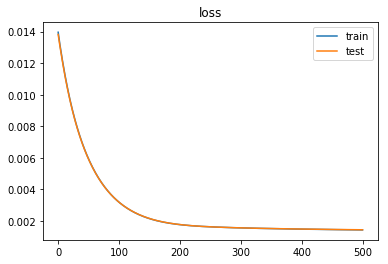

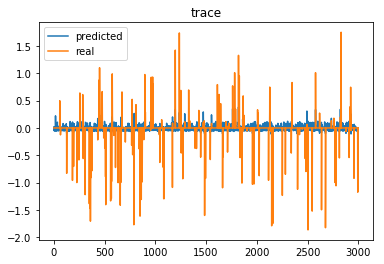

In [20]:
# Define model
    ### Add your code here. ###
model = Regressor(SimpleRNN(4))

# Train model
    ### Add your code here. ###
model, train_loss, test_loss = train_network(model, 3000, 500)

# Plot losses
    ### Add your code here. ###
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(["train", "test"])
plt.title("Loss")
plt.show()

# Plot predictions vs. real data
    ### Add your code here. ###
test_network(model, 3000)

Looking at the losses it seems to be doing fine. However if we look at the plot of predicted vs. real its not that good. It just kinda predicts the average. 

### Exercise 4: LSTM RNN (2 points)

Long-Short Term Memory (LSTM) units have more [powerful functionality](http://colah.github.io/posts/2015-08-Understanding-LSTMs/), such as selective forgetting, and they are able to keep track of long-term dependencies. This might be useful for the adding task. 

Implement `LSTM_RNN`:

1. `lstm` should be an `LSTM` layer leading from the `n_input` inputs to the `n_hidden` hidden units.
1. `fc` should be a fully-connected (linear) layer leading from the hidden units (output of `lstm`) to the `n_out` output units. 
1. The network does not make use of further activation functions. 
1. Fill in the function `reset_state()` by calling the reset function (with the same name) on the `lstm` layer there.

### Solution 4

In [23]:
class LSTM_RNN(Chain):
    
    def __init__(self, n_hidden, n_input=2, n_out=1):
        super(LSTM_RNN, self).__init__()
        with self.init_scope():
            ### Add your code here. ###
            self.lstm = L.LSTM(n_input, n_hidden)
            self.fc = L.Linear(n_hidden, n_out)
    
    def __call__(self, x):
            ### Add your code here. ###
        y = self.fc(self.lstm(x))
        return y
    
    def reset_state(self):
            ### Add your code here. ###
        self.lstm.reset_state()

### Exercise 5: Setup and run (1 point)

Try your `LSTM_RNN` with the dynamic addition task. 

1. Define the model. `LSTM_RNN` should have **2 hidden units** and become the predictor of a `Regressor` instance.  
1. Train your model for 2000 epochs on a dataset of 3000 samples with `train_network`. 
1. Plot the train and validation losses. 
1. Finally, use the trained model together with `test_network` (at least 500 examples) to observe how predictions and real data compare. 

Did the LSTM network capture the task better? Did any of the two capture the task perfectly? Or are the two networks on par? 

### Solution 5

In [ ]:
# Define model
    ### Add your code here. ###
model = Regressor(LSTM_RNN(2))

# Train model
    ### Add your code here. ###
model, train_loss, test_loss = train_network(model, 3000, 2000)

# Plot losses
    ### Add your code here. ###
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(["train", "test"])
plt.title("Loss")
plt.show()

# Plot predictions vs. real data
    ### Add your code here. ###
test_network(model, 3000)

 78%|█████████████████████████████▊        | 1570/2000 [09:02<02:28,  2.89it/s]

The LSTM_RNN is much better than the SimpleRNN. The loss is around 10 times as small. Also if we look at predicted vs. real there seems to be real overlap. While not perfectly predicting, the LSTM comes very close. So we conclude that the LSTM learns the task better. Note that the LSTM took more epochs/training time to train (four times as much). 